__Realism and Complexity__

Up to now, we've fitted some fairly crude and unrealistic lens models. For example, we've modeled the lens galaxy's mass as a sphere. Given most lens galaxies are 'elliptical' galaxies, we should probably model their mass as elliptical! We've also omitted the lens galaxy's light, which typically outshines the source galaxy. 

In this example, we'll start using a more realistic lens model.

In my experience, the simplest lens model (e.g. that has the fewest parameters) that provides a good fit to real strong lenses is as follows:

1) An elliptical Sersic light-profile for the lens galaxy's light.
2) A singular isothermal ellipsoid (SIE) mass-profile for the lens galaxy's mass.
3) An elliptical exponential light-profile for the source galaxy's light (to be honest, this is too simple, but lets worry about that later).

This has a total of 18 non-linear parameters, which is over double the number of parameters we've fitted up to now. In future exercises, we'll fit even more complex models, with some 20-30+ non-linear parameters.

The goal of this, rather short, exercise, is to fit this 'realistic' model to a simulated image, where the lens's light is visible and mass is elliptical. What could go wrong?

In [1]:
import autofit as af
import autolens as al

You need to change the path below to the chapter 1 directory.

In [2]:
chapter_path = "/path/to/user/autolens_workspace/howtolens/chapter_2_lens_modeling/"
chapter_path = "/home/jammy/PycharmProjects/PyAuto/autolens_workspace/howtolens/chapter_2_lens_modeling/"

af.conf.instance = af.conf.Config(
    config_path=chapter_path + "configs/t3_realism_and_complexity/",
    output_path=chapter_path + "output/",
)

Another simulate image function, which generates a different Imaging data-set from the first two tutorials.

In [3]:
def simulate():

    psf = al.kernel.from_gaussian(shape_2d=(11, 11), sigma=0.05, pixel_scales=0.05)

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        light=al.lp.EllipticalSersic(
            centre=(0.0, 0.0),
            axis_ratio=0.9,
            phi=45.0,
            intensity=0.04,
            effective_radius=0.5,
            sersic_index=3.5,
        ),
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8
        ),
    )

    source_galaxy = al.Galaxy(
        redshift=1.0,
        light=al.lp.EllipticalSersic(
            centre=(0.0, 0.0),
            axis_ratio=0.5,
            phi=90.0,
            intensity=0.03,
            effective_radius=0.3,
            sersic_index=3.0,
        ),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    simulator = al.simulator.imaging(
        shape_2d=(130, 130),
        pixel_scales=0.1,
        exposure_time=300.0,
        sub_size=1,
        psf=psf,
        background_level=0.1,
        add_noise=True,
    )

    return simulator.from_tracer(tracer=tracer)

Simulate the Imaging data.

In [4]:
imaging = simulate()

When plotted, the lens light's is clearly visible in the centre of the image.

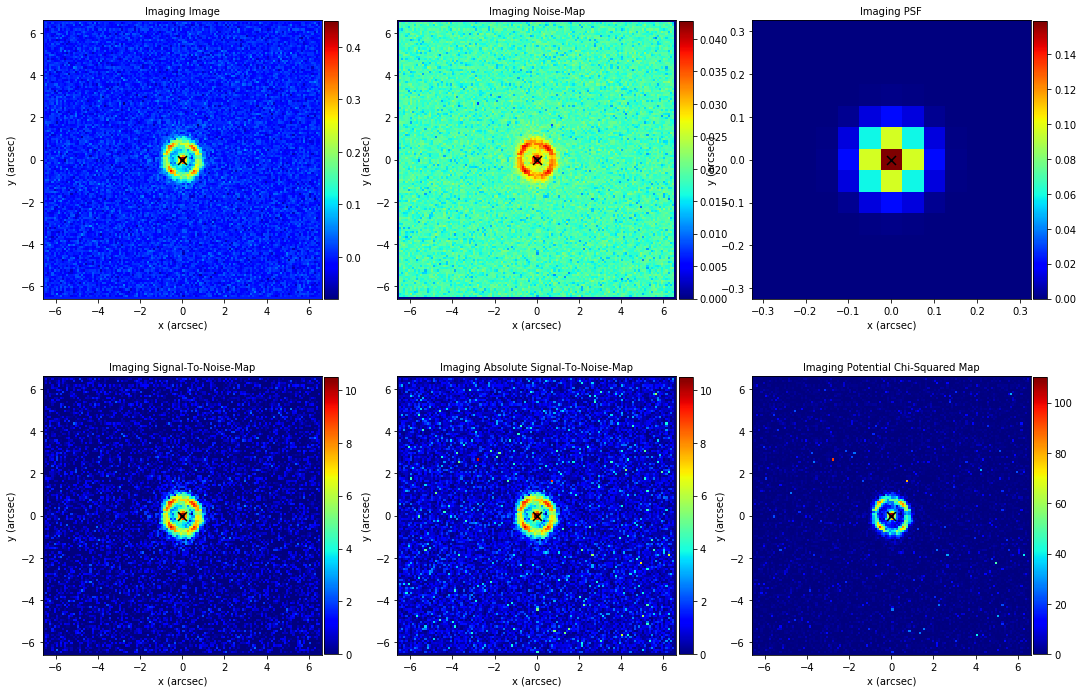

In [5]:
al.plot.imaging.subplot(imaging=imaging)

Now lets fit it using a phase, noting that our galaxy-model corresponds to the one used in the simulate function above.

Because we now have 18 non-linear parameters, the non-linear search takes a lot longer to run. On my laptop, this phase took around an hour, which is a bit too long for you to wait if you want to go through these tutorials quickly.
Therefore, as discussed before, I've included the results of this non-linear search already, allowing you to go through the tutorial as if you had actually run them.

Nevertheless, you could try running it yourself (maybe over your lunch break?). All you need to do is change the phase_name below, maybe to something like 'howtolens/3_realism_and_complexity_rerun'

In [6]:
phase = al.PhaseImaging(
    phase_name="phase_t3_realism_and_complexity",
    galaxies=dict(
        lens_galaxy=al.GalaxyModel(
            redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source_galaxy=al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalExponential),
    ),
    optimizer_class=af.MultiNest,
)

Lets run the phase.

In [7]:
print(
    "MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/3_realism_and_complexity"
    "folder for live output of the results, images and lens model."
    "This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!"
)

results = phase.run(dataset=imaging)

print("MultiNest has finished run - you may now continue the notebook.")

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/3_realism_and_complexityfolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!
Recursion wrapper received item <autofit.mapper.model_mapper.ModelMapper object at 0x7f8a0a7d81d0>
This gives item_id 140230858211792. Cache keys = 
item not in cache
Recursion wrapper received item 30
This gives item_id 10915424. Cache keys = 140230858211792
item not in cache
Recursion wrapper received item <autofit.mapper.prior_model.collection.CollectionPriorModel object at 0x7f8a0a7d8780>
This gives item_id 140230858213248. Cache keys = 140230858211792
item not in cache
Recursion wrapper received item 31
This gives item_id 10915456. Cache keys = 140230858211792,140230858213248
item not in cache
Recursion wrapper received item 0
This gives item_id 10914464. Cache keys = 140230858211792,140230858213248
item not

/home/jammy/PycharmProjects/VirtualEnvs/PyAuto/lib/python3.6/site-packages/getdist/chains.py:1022: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  weights = np.hstack((chain.weights for chain in self.chains))
/home/jammy/PycharmProjects/VirtualEnvs/PyAuto/lib/python3.6/site-packages/getdist/chains.py:1023: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  loglikes = np.hstack((chain.loglikes for chain in self.chains))
/home/jammy/PycharmProjects/VirtualEnvs/PyAuto/lib/python3.6/site-packages/getdist/chains.py:1024: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators i

/home/jammy/PycharmProjects/PyAuto/autolens_workspace/howtolens/chapter_2_lens_modeling/output/phase_t3_realism_and_complexity/phase_tag__sub_2/optimizer_backup/multinest.txt
Removed no burn in
MultiNest has finished run - you may now continue the notebook.


And lets look at the fit to the Imaging data.

In [ ]:
al.plot.fit_imaging.subplot(
    fit=results.most_likely_fit,
    include_mask=True,
)

Uh-oh. That fit doesn't look very good, does it? If we compare our inferred parameters (look at the 'autolens_workspace/howtolens/chapter_2_lens_modeling/output/3_realism_and_complexity' folder to the actual values (in the simulate function) you'll see that we have, indeed, fitted the wrong model.

Yep, we've inferred the wrong lens model. Or have we? Maybe you're thinking that this model provides an even higher likelihood than the correct solution? Lets make absolutely sure it doesnt: (you've seen all this code below before, but I've put a few comments to remind you of whats happening).

In [ ]:
mask = al.mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=2, radius_arcsec=3.0
)

masked_imaging = al.masked.imaging(imaging=imaging, mask=mask)

al.plot.imaging.image(
    imaging=imaging, mask=mask
)

# Make the tracer we use to Simulate the Imaging data
lens_galaxy = al.Galaxy(
    redshift=0.5,
    light=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        axis_ratio=0.9,
        phi=45.0,
        intensity=0.04,
        effective_radius=0.5,
        sersic_index=3.5,
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        axis_ratio=0.5,
        phi=90.0,
        intensity=0.03,
        effective_radius=0.3,
        sersic_index=3.0,
    ),
)

tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, source_galaxy],
)

Now, lets fit the lens-data with the tracer and plot the fit. It looks a lot better than above, doesn't it?

In [ ]:
correct_fit = al.fit(masked_dataset=masked_imaging, tracer=tracer)

al.plot.fit_imaging.subplot(fit=correct_fit, include_mask=True)

Finally, just to be sure, lets compare the two likelihoods.

In [ ]:
print("Likelihood of Non-linear Search:")
print(results.most_likely_fit.likelihood)
print("Likelihood of Correct Model:")
print(correct_fit.likelihood)

Well, there we have it, the input model has a much higher likelihood than the one our non-linear search inferred.

Clearly, our non-linear search failed. So, what happened? Where did it all go wrong?

Lets think about 'complexity'. As we made our lens model more realistic, we also made it more complex. Our non-linear parameter space went from 7 dimensions to 18. This means there was a much larger 'volume' of parameter space to search. Maybe, therefore, our non-linear search got lost. It found some region of parameter space that it thought was the highest likelihood region and focused the rest of its search there. But it was mistaken, there was in fact another region of parameter space with even higher likelihood solutions.

This region - the one our non-linear search failed to locate - is called the global maximum likelihood region, or 'global maxima'. The region we found instead is called a 'local maxima' At its core, lens modeling is all about learning how to get a non-linear search to find the global maxima region of parameter space, even when the lens model is extremely complex.

If you did run the phase above yourself, you might of actually inferred the correct lens model. There is some level of randomness in a non-linear search. This means that sometimes, it might find a local maxima and other times a  global maxima. Nevertheless, as lens models become more complex, you'll quickly find yourself stuck in local maxima unless you learn how to navigate parameter spaces better.


And with that, we're done. In the next exercise, we'll learn how to deal with our failures and begin thinking about how we can ensure our non-linear search finds the global-maximum likelihood solution. Before that, think about the following:

1) When you look at an image of a strong lens, do you get a sense of roughly what values certain lens model parameters are?

2) The non-linear search failed because parameter space was too complex. Could we make it less complex, whilst still keeping our lens model fairly realistic?

3) The source galaxy in this example had only 6 non-linear parameters. Real source galaxies may have multiple components (e.g. a bar, disk, bulge, star-forming knot) and there may even be more than 1 source galaxy! Do you think there is any hope of us navigating a parameter space if the source contributes 20+ parameters by itself?
